# ISBN Clustering

In [1]:
library(data.table)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


In [2]:
options(repr.plot.height=5)

In [147]:
Rcpp::sourceCpp("isbn.cpp")

In [3]:
db = DBI::dbConnect(RPostgreSQL::PostgreSQL(), dbname='openlib')

## Clustering Algorithm

We cluster ISBNs by taking the bipartite graph of ISBNs and records, and computing the closure for each ISBN.  Each closure becomes a cluster with a single ‘book’ ID.

In [35]:
Rcpp::sourceCpp("cluster.cpp")
cluster_isbns = function(isbn_rec_tbl) {
    message("initializing clusters")
    clusters = isbn_rec_tbl %>% group_by(isbn) %>% summarize(cluster=min(record)) %>% ungroup() %>%
        mutate(cluster = as.integer(cluster))
    message("populating edges")
    edges = isbn_rec_tbl %>%
        rename(left_isbn = isbn) %>%
        inner_join(isbn_rec_tbl %>% rename(right_isbn = isbn)) %>%
        select(left_isbn, right_isbn) %>%
        distinct()
    message("clustering ", nrow(clusters), " isbns with ", nrow(edges), " edges")
    c2 = compute_clusters(clusters, edges)
    message("built ", length(unique(c2$cluster)), " clusters")
    c2
}

## Library of Congress

In [36]:
loc_rec_isbns = db %>% tbl('loc_isbn') %>% select(isbn, rec_id) %>% collect()
print(loc_rec_isbns)

# A tibble: 6,600,638 x 2
   isbn        rec_id
 * <chr>        <int>
 1 0687132924 2784948
 2 8473512243 2784949
 3 9682301084 2784951
 4 0316493953 2784970
 5 0202301575 2784977
 6 0912832177 2784985
 7 0675093686 2784988
 8 9686021086 2785001
 9 0716501864 2785015
10 0871622092 2785038
# ... with 6,600,628 more rows


In [37]:
loc_isbn_ids = loc_rec_isbns %>% select(isbn) %>% distinct() %>% mutate(id=1:n())
print(loc_isbn_ids)

# A tibble: 6,524,465 x 2
   isbn          id
   <chr>      <int>
 1 0687132924     1
 2 8473512243     2
 3 9682301084     3
 4 0316493953     4
 5 0202301575     5
 6 0912832177     6
 7 0675093686     7
 8 9686021086     8
 9 0716501864     9
10 0871622092    10
# ... with 6,524,455 more rows


In [38]:
loc_rec_edges = loc_rec_isbns %>% inner_join(loc_isbn_ids) %>% select(isbn=id, record=rec_id)
print(loc_rec_edges)

Joining, by = "isbn"


# A tibble: 6,600,638 x 2
    isbn  record
   <int>   <int>
 1     1 2784948
 2     2 2784949
 3     3 2784951
 4     4 2784970
 5     5 2784977
 6     6 2784985
 7     7 2784988
 8     8 2785001
 9     9 2785015
10    10 2785038
# ... with 6,600,628 more rows


In [39]:
loc_clusters = cluster_isbns(loc_rec_edges)

initializing clusters
populating edges
Joining, by = "record"
clustering 6524465 isbns with 10491947 edges
[    0.00] starting iteration 1
[    0.35] iteration 1 changed 23967 memberships
[    0.36] starting iteration 2
[    0.70] iteration 2 changed 371 memberships
[    0.71] starting iteration 3
[    1.06] iteration 3 changed 2 memberships
[    1.07] starting iteration 4
[    1.42] iteration 4 changed 0 memberships
built 5186987 clusters


How big are our largest clusters?

In [40]:
cluster_sizes = loc_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
9927813,162
44464,129
7451086,123
2577188,116
6446243,98
7394785,84


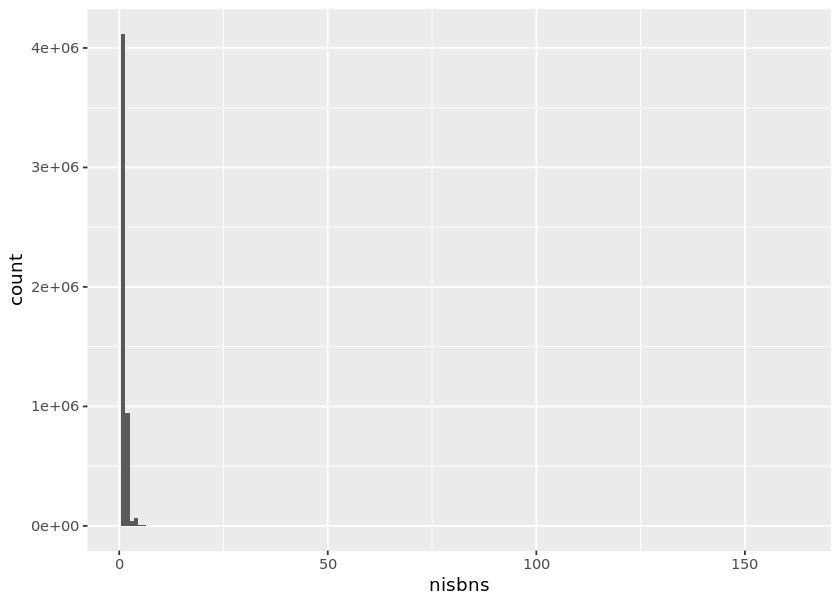

In [87]:
ggplot(cluster_sizes) +
    aes(x=nisbns) +
    geom_histogram(binwidth=1)

In [41]:
loc_clusters %>% rename(id=isbn) %>% inner_join(loc_isbn_ids) %>% select(isbn, cluster) %>%
    copy_to(db, ., name='loc_isbn_cluster', overwrite=TRUE, temporary=FALSE,
            unique_indexes=list("isbn"), indexes=list("cluster"))

Joining, by = "id"


## OpenLibrary

In [42]:
ol_rec_edges = db %>% tbl('ol_isbn_link') %>% select(isbn=isbn_id, record=book_code) %>% 
    collect()

In [43]:
print(ol_rec_edges)

# A tibble: 21,062,688 x 2
       isbn    record
 *    <int>     <int>
 1  1503099 105437266
 2  2659462 105437266
 3  5372388 112604572
 4 12702878 112604572
 5  2276794 102386629
 6  4327917 102386629
 7 15824799 105798955
 8 12504108 102066511
 9  8742366 102066511
10 10151017 110581121
# ... with 21,062,678 more rows


In [44]:
ol_clusters = cluster_isbns(ol_rec_edges)

initializing clusters
populating edges
Joining, by = "record"
clustering 18404050 isbns with 205979114 edges
[    0.00] starting iteration 1
[   24.46] iteration 1 changed 1195345 memberships
[   24.47] starting iteration 2
[   48.12] iteration 2 changed 63128 memberships
[   48.13] starting iteration 3
[   72.33] iteration 3 changed 8505 memberships
[   72.34] starting iteration 4
[   96.09] iteration 4 changed 1428 memberships
[   96.10] starting iteration 5
[  120.21] iteration 5 changed 81 memberships
[  120.21] starting iteration 6
[  144.08] iteration 6 changed 12 memberships
[  144.09] starting iteration 7
[  168.12] iteration 7 changed 0 memberships
built 9829550 clusters


In [45]:
ol_cluster_sizes = ol_clusters %>% group_by(cluster) %>% summarize(nisbns=n()) %>% ungroup() 
ol_cluster_sizes %>% arrange(-nisbns) %>% head()

cluster,nisbns
105077683,7520
100339351,6518
100004153,5178
107956464,4276
106611855,2820
100058368,2111


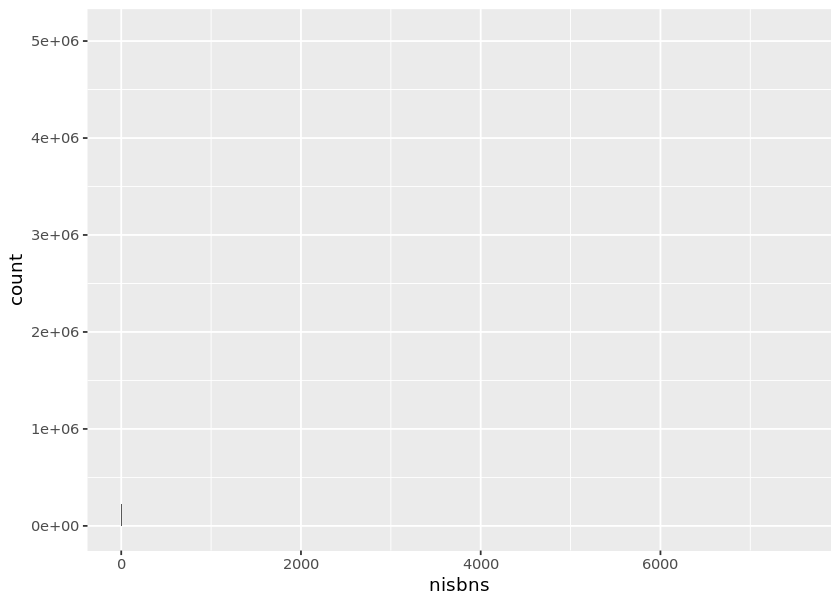

In [46]:
ggplot(ol_cluster_sizes) +
    aes(x=nisbns) +
    geom_histogram(binwidth=1)

In [53]:
ol_cluster_sizes = ol_cluster_sizes %>% mutate(bucket = as.integer(log10(nisbns)))
ol_cluster_buckets = ol_cluster_sizes %>% filter(nisbns > 1) %>% group_by(bucket) %>% summarize(n=n())
ol_cluster_buckets

bucket,n
0,5889835
1,49021
2,397
3,12


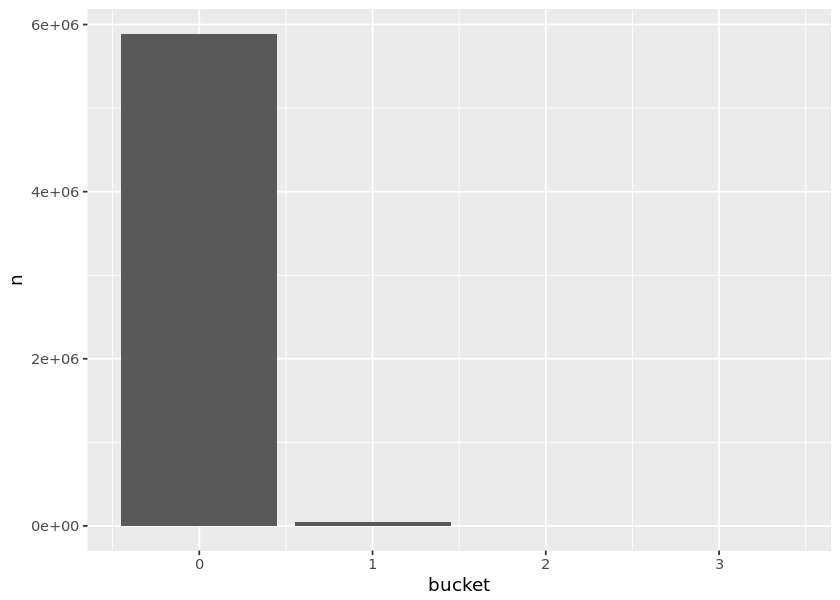

In [54]:
ggplot(ol_cluster_buckets) +
    aes(x=bucket, y=n) +
    geom_bar(stat='identity')

In [47]:
ol_clusters %>% select(isbn_id=isbn, cluster) %>%
    copy_to(db, ., name='ol_isbn_cluster', overwrite=TRUE, temporary=FALSE,
            unique_indexes=list("isbn_id"), indexes=list("cluster"))

### Load ISBN info to work on checking clusters

In [55]:
ol_isbn_ids = db %>% tbl('ol_isbn_id') %>% collect()
print(ol_isbn_ids)

# A tibble: 18,404,050 x 2
   isbn_id isbn         
 *   <int> <chr>        
 1       1 4770030452   
 2       2 9780760708552
 3       3 0789317915   
 4       4 9780828313650
 5       5 0813372720   
 6       6 2738452264   
 7       7 0538264500   
 8       8 3257219210   
 9       9 0751528455   
10      10 9780575085039
# ... with 18,404,040 more rows


How many ISBNs are in LOC but not OL?

In [61]:
missing_isbns = loc_isbn_ids %>% anti_join(ol_isbn_ids)
nrow(missing_isbns)

Joining, by = "isbn"


[1] 883782

That is quite a few. What are their lengths?

In [66]:
missing_isbns %>% group_by(len=str_length(isbn)) %>% summarize(n=n()) %>% arrange(len)

len,n
1,3
2,15
3,80
4,7
5,5
6,8
7,96
8,29
9,310
10,470027


What are our validity stats of ISBNs from each database?

In [111]:
loc_isbn_ids %>% mutate(valid = is_valid_isbn(isbn)) %>% pull(valid) %>% summary()

   Mode   FALSE    TRUE 
logical 1499638 5024827 

In [112]:
ol_isbn_ids %>% mutate(valid = is_valid_isbn(isbn)) %>% pull(valid) %>% summary()

    Mode    FALSE     TRUE 
 logical  7507316 10896734 

In [113]:
ol_isbn_ids %>% mutate(valid = is_valid_isbn(isbn)) %>% filter(!valid, str_length(isbn) == 10) %>% head()

isbn_id,isbn,valid
407,979868073X,FALSE
779,9773190308,FALSE
1950,3760833732,FALSE
1979,0295953378,FALSE
2553,0190479877,FALSE
2556,0971089761,FALSE


What are our ISBN lengths from OL?

In [117]:
ol_isbn_ids %>% group_by(length=str_length(isbn)) %>% summarize(n=n())

length,n
1,10
2,34
3,72
4,148
5,181
6,282
7,646
8,1740
9,20977
10,10939631


### LOC Cluster Splits
Do any LOC clusters split into multiple OL clusters?

In [120]:
cluster_pairs = loc_clusters %>% rename(id=isbn) %>% 
    inner_join(loc_isbn_ids) %>%
    inner_join(ol_isbn_ids) %>%
    inner_join(rename(ol_clusters, isbn_id=isbn, ol_cluster=cluster)) %>%
    select(cluster, ol_cluster) %>%
    distinct()

Joining, by = "id"
Joining, by = "isbn"
Joining, by = "isbn_id"


In [123]:
nrow(cluster_pairs)

[1] 4679681

In [126]:
multi_clusters = cluster_pairs %>% group_by(cluster) %>% summarize(n=n()) %>% filter(n > 1)
print(multi_clusters)

# A tibble: 20,060 x 2
   cluster     n
     <int> <int>
 1    1838     2
 2    1882     2
 3    1892     2
 4    1915     2
 5    1955     2
 6    1978     2
 7    2017     2
 8    2144     2
 9    2147     2
10    2173     2
# ... with 20,050 more rows


In [129]:
cluster_pairs %>% filter(cluster == 1838)

cluster,ol_cluster
1838,217590345
1838,210692460


In [135]:
loc_clusters %>% filter(cluster == 1838) %>% rename(id=isbn) %>% inner_join(loc_isbn_ids)

Joining, by = "id"


id,cluster,isbn
5799665,1838,0761920706
5799666,1838,0761920714


In [136]:
ol_clusters %>% filter(cluster == 217590345) %>% rename(isbn_id=isbn) %>% inner_join(ol_isbn_ids)

Joining, by = "isbn_id"


isbn_id,cluster,isbn
1930343,217590345,0761920706
7590303,217590345,9780761920700


In [137]:
ol_clusters %>% filter(cluster == 210692460) %>% rename(isbn_id=isbn) %>% inner_join(ol_isbn_ids)

Joining, by = "isbn_id"


isbn_id,cluster,isbn
772722,210692460,0761920714
3331543,210692460,9780761920717


In [151]:
is_valid_isbn("9780761920717")

[1] FALSE

In [127]:
tribble(
    ~metric, ~value,
    "LOC Clusters", length(unique(loc_clusters$cluster)),
    "Split LOC Clusters", nrow(multi_clusters),
    "OL Clusters", length(unique(ol_clusters$cluster))
)

metric,value
LOC Clusters,5186987
Split LOC Clusters,20060
OL Clusters,9829550
